In [1]:
# Importing required libraries for loading and storing the data from the matlab datafiles
from pymatreader import read_mat
import pandas as pd

# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [120]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    data = read_mat('B00' + num + '.mat')
    df = pd.DataFrame(data['B00' + num]['cycle'])

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

# This function plots the data of specified type (voltage, current or temperature)
# for the cycle numbers specified by "cycle_list" argument
def dc_cycle_plots(cell_number, cycle_list, type, figsize = (10,5), only_scatter = False):
    _, discharge, _= split_data(cell_number)

    labels = {'voltage': 'Battery terminal voltage (V)',
              'current': 'Battery output current (A)',
              'temperature': 'Battery temperature (°C)'}
    type_ = type.capitalize() + '_measured'

    plt.figure(figsize = figsize)
    for cycle in cycle_list:
        time_data = discharge.iloc[cycle]['data']['Time']   # List of times obtained from the "discharge" dataframe
        type_data = discharge.iloc[cycle]['data'][type_]    # Data of the type specified, obtained from the "discharge" dataframe
        
        if not only_scatter: plt.plot(time_data, type_data, label = f"cycle {cycle}")
        plt.scatter(time_data, type_data, s = 5)
    plt.title(f"{type.capitalize()} Measured for cell number {cell_number}", fontsize = 14)
    plt.xlabel("Time (seconds)", fontsize = 14)
    plt.ylabel(labels[type], fontsize = 14)
    plt.legend()
    plt.show()

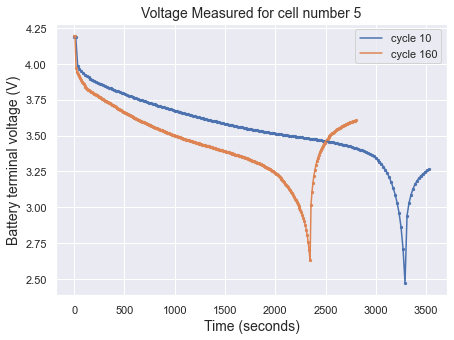

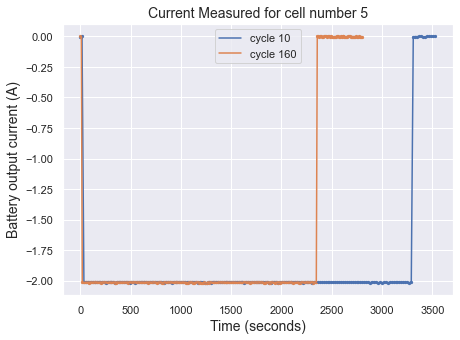

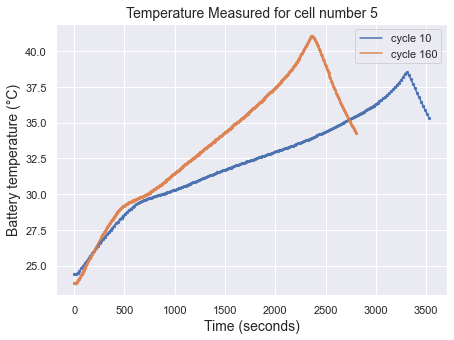

In [121]:
cycles = [10,160]
dc_cycle_plots(5, cycles, 'voltage', figsize = (7,5), only_scatter = False)
dc_cycle_plots(5, cycles, 'current', figsize = (7,5), only_scatter = False)
dc_cycle_plots(5, cycles, 'temperature', figsize = (7,5), only_scatter = False)

In [41]:
def preprocessing(cell_number, voltage_splits = 16):
    _, discharge, _ = split_data(cell_number)
    voltages = np.linspace(2.7, 4, voltage_splits)
    
    # features0 stores the Times at which terminal voltage is 2.7, ..., 4
    # features1 stores the Time to reach minimum terminal voltage
    # feature2 stores the Maximum temperature
    # feature3 stores the Time to reach maximum temperature
    
    feature0, feature1, feature2, feature3 = [], [], [], []
    for i in range(len(discharge)):
        time_data = discharge.iloc[i]['data']['Time']                       # Getting time data from the discharge dataframe
        voltage_data = discharge.iloc[i]['data']['Voltage_measured']        # Getting voltage data
        temp_data = discharge.iloc[i]['data']['Temperature_measured']       # Getting temperature data

        times = []
        for j in range(voltage_splits):
            time_for_closest_voltage = time_data[np.argmin(np.abs(voltage_data - voltages[j]))]         # time at which the reading stored in "voltage_data" is closest 
            times.append(time_for_closest_voltage)                                                      # to one of the values in the "voltages" array
        
        feature0 = feature0 + [times]
        feature1.append(time_data[np.argmin(voltage_data)])
        feature2.append(np.max(temp_data))

        time_for_max_temp = time_data[np.argmax(temp_data)]                 # time at which temperature reaches its maximum value
        feature3.append(time_for_max_temp)

    # Using list comprehension: 
    # feature0 = [[discharge.iloc[i]['data']['Time'][np.argmin(np.abs(discharge.iloc[i]['data']['Voltage_measured'] - voltages[j]))] for j in range(len(voltages))] for i in range(len(discharge))]
    # feature1 = [discharge.iloc[i]['data']['Time'][np.argmin(discharge.iloc[i]['data']['Voltage_measured'])] for i in range(len(discharge))]
    # feature2 = [np.max(discharge.iloc[j]['data']['Temperature_measured']) for j in range(len(discharge))]
    # feature3 = [discharge.iloc[j]['data']['Time'][np.argmax(discharge.iloc[j]['data']['Temperature_measured'])] for j in range(len(discharge))]

    x = np.array(feature0)
    feature1 = np.array(feature1)
    feature1 = feature1[:, np.newaxis]

    feature2 = np.array(feature2)
    feature2 = feature2[:, np.newaxis]

    feature3 = np.array(feature3)
    feature3 = feature3[:, np.newaxis]

    x = np.hstack((x, feature1, feature2, feature3))
    y = np.array([discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))])
    
    return x, y

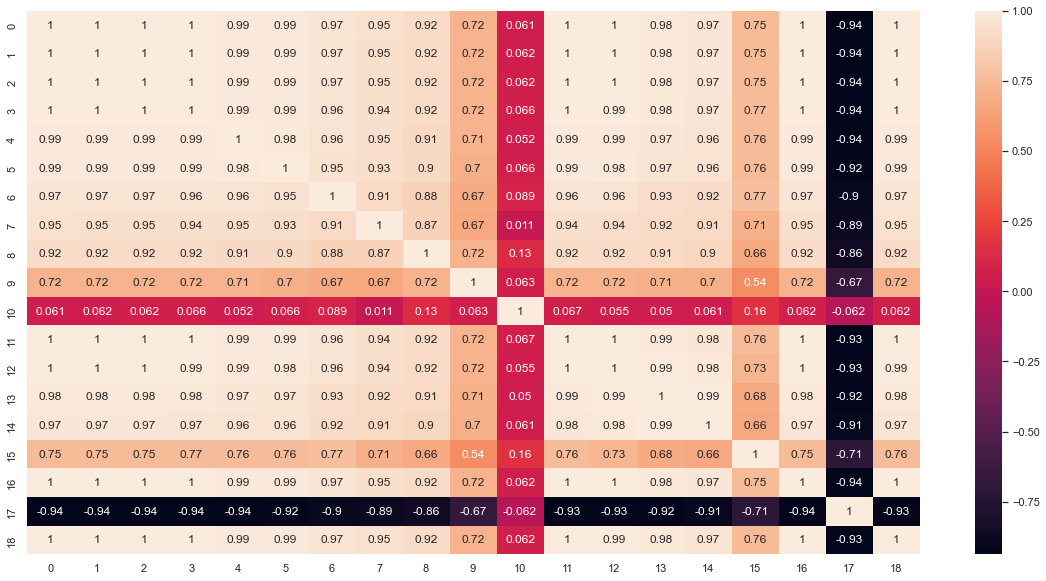

In [43]:
x, y = preprocessing(5, 16)

# Plot a correlation matrix to determine if there are any redundancies
corr = pd.DataFrame(x).corr()

# Plotting a heatmap between continuous variables
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, 
                 xticklabels=corr.columns,
                 yticklabels=corr.columns,
                 annot=True)

In [45]:
# Import some additional libraries for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [78]:
# This function prepares the x and y data for training by performing the test-train split, 
# and applying StandardScaler to normalize the values
def prep_for_training(x, y, scale_config = True):
    global scaler
    
    # Split the data in the ratio 80:20 for training, testing respectively
    train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8)

    if scale_config:
        # Standardize the training data
        scaler = StandardScaler()
        # Fit the scaler to X_train
        scaler.fit(train_x)

    # Transform the entire data using the computed mean and variance
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    train = [train_x, train_y]
    test = [test_x, test_y]
    
    return train, test

8 components are sufficient to satisfy the RMSE reconstruction criterion


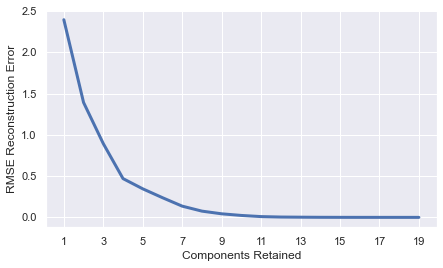

In [132]:
x, y = preprocessing(5, 16)     # using cell 5 for training
[train_x, train_y], [test_x, test_y] = prep_for_training(x, y)

# Import the module for PCA
from sklearn.decomposition import PCA

# Re-centre the data to have zero mean
X_for_pca = train_x - np.mean(train_x, axis=0)[np.newaxis, :]

# Compute std. deviation of L2 norm input vectors
l2_norm = np.sum(X_for_pca ** 2, axis=-1)
std_dev = np.std(l2_norm)

# Threshold for dimensionality reduction set to 1% of std. deviation
threshold = 0.01 * std_dev

rmse_vs_components = []   # List of RMSE vs n_components for plotting
desired_components = 19   # Start by assuming all components are necessary

# Iterate over number of retained dimensions
for n_components in range(1, 20):
    pca = PCA(n_components=n_components)

    # Fit PCA onto the input data
    pca.fit(X_for_pca)

    # Apply dimensionality reduction on X
    X_transformed = pca.transform(X_for_pca)

    # Transform back to the starting space to compute reconstruction error
    X_projected = pca.inverse_transform(X_transformed)

    # Compute RMSE reconstruction error
    rmse = np.sum((X_for_pca - X_projected) ** 2, axis=-1).mean()

    if rmse < threshold:
        desired_components = min(n_components, desired_components)

    rmse_vs_components.append(rmse)

# Plot RMSE vs Components Retained
plt.figure(figsize=(7, 4))
plt.xlabel('Components Retained', fontsize=12)
plt.ylabel('RMSE Reconstruction Error', fontsize=12)
plt.plot(np.arange(1, 20), rmse_vs_components, lw=3)
plt.xticks(np.arange(1, 20, 2))

print(red(f"{desired_components}", 'bold'), "components are sufficient to satisfy the RMSE reconstruction criterion")

In [104]:
n_components = desired_components # Sufficient dimensions after compression

# PCA with 8 retained dimensions
pca = PCA(n_components=n_components)
pca.fit(X_for_pca)

train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

# Print the shape for confirmation
print(train_x.shape)
print(test_x.shape) 

(134, 8)
(34, 8)


In [105]:
from simple_colors import *

def eval_svr(train, test, training = True):
    global svr

    if training:
        # Define a SVM regressor with a Gaussian kernel
        svr = SVR()

        # Train the model
        svr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
    print(f"R2 Score = {svr.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(svr.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_mlp(train, test, training = True, layer_size = 100, max_iter = 100):
    global mlp
    
    if training: 
        # Define a regressor with 1 hidden layer
        mlp = MLPRegressor(hidden_layer_sizes = (layer_size,), max_iter = max_iter)
        # Train the model
        mlp.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Multi-Layer Perceptron...", 'bold'))
    print(f"R2 Score = {mlp.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(mlp.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_rf(train, test, training = True, n_estimators = 100):
    global regressor
    
    if training:
        # Define a random forest regressor
        regressor = RandomForestRegressor(n_estimators = n_estimators)
        # Train the model
        regressor.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
    print(f"R2 Score = {regressor.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(regressor.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

In [106]:
train, test = [train_x, train_y], [test_x, test_y]

eval_svr(train, test)
#eval_mlp(train, test)
eval_rf(train, test)

Evaluating the Support Vector Regressor...
R2 Score = 0.8997
RMSE = 0.0582
Evaluating the Random Forest Regressor...
R2 Score = 0.9954
RMSE = 0.0125


In [114]:
def evaluate_cell(cell_number):
    x, y = preprocessing(cell_number, 16)
    x = scaler.transform(x)
    x = pca.transform(x)

    eval_svr(_, [x, y], training = False)
    #eval_mlp(train, test)
    eval_rf(_, [x, y], training = False)
    
    plt.figure(figsize = (10,5))
    plt.plot(svr.predict(x), label = "Support Vector Regressor")
    plt.plot(regressor.predict(x), label = "Random Forest Regressor")
    plt.plot(y.reshape(-1,1), label = "True labels")
    plt.legend()
    plt.ylabel("Capacity of the battery (Ahr)", fontsize = 14)
    plt.show()

Evaluating the Support Vector Regressor...
R2 Score = 0.8163
RMSE = 0.0688
Evaluating the Random Forest Regressor...
R2 Score = 0.9765
RMSE = 0.0246


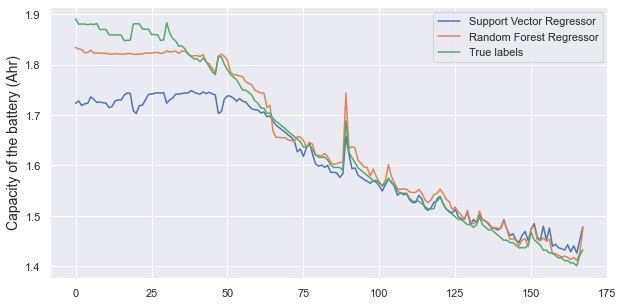

In [115]:
evaluate_cell(7)